# POPPY Simulation: MagAO-X for PDR (Version: No aberrations)
## Notes: 
- This file has no aberrations present on the optical surfaces. Please check the main file to see the version with surfaces applied: https://github.com/jlumbres/magaox_poppy/blob/master/magaox_pdr.ipynb

- The lack of aberrations present makes it easier to check for any correction distances at various F/# focal planes. Try working on this file to get the correction distance before going to the file with surfaces applied.

- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.

- All the commented code below is for the intermediary F/# wavefront corrections. Uncomment them if need to check or recalculate correction factor from adding new optical element.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file.

### Optical elements not implemented currently:
- ADC1 (surface 4&5, 7&8)
- ADC2 (surface 6&7, 9&10)

### To-do Tasks:
- Fix the path to go through the coronagraph path.

In [2]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
lyot_stop_diam = 0.009 * u.m

# radius of curvature values
fl_M1 = 8.128 * u.m
fl_M2 = (2.862820/2) * u.m

# Math check for the OAPs in the zemax file
oap_roc = np.array([204.431, 337.544, 589.294, 2106.685, 1008.520, 1220.84, 1220.84, 1220.84]) / 1000 # convert mm to m
oap_angle = np.array([65, 53, 20, 15, 15, 15, 15, 15])
oap_fl = oap_roc/(1+np.cos(np.deg2rad(oap_angle))) # equation defined in a presentation somewhere

# propagation distances based on Zemax
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_wfsdichroic = 4.849516 * u.m
d_wfsdichroic_peri1 = 0.100 * u.m
d_peri1_f11fp = 0.030 * u.m
d_f11fp_peri2 = 0.033204 * u.m
d_peri2_oap0 = 0.010 * u.m # Note: d_f11fp_oap0 for zemax and design spreadsheet don't match
d_oap0_k1 = 0.081125 * u.m
d_k1_k2 = 0.025 * u.m
d_k2_k3 = 0.025 * u.m
d_k3_woofer = 0.055 * u.m
d_woofer_oap1 = 0.252681 * u.m
d_oap1_fold1 = 0.040 * u.m
d_fold1_f16fp = 0.141569 * u.m
d_f16fp_oap2 = 0.276877 * u.m
d_oap2_tweeter = 0.312968 * u.m
d_tweeter_oap3 = 1.089857 * u.m
d_oap3_breadfm1 = 0.28585 * u.m
d_breadfm1_breadfm2 = 0.573655 * u.m
d_breadfm2_f57fp = 0.157943 * u.m
d_f57fp_oap4 = 0.487078 * u.m
d_oap4_flat6 = 0.312829 * u.m
d_flat6_ttm = 0.208912 * u.m # Note: got this number by adding through ADC1 and 2
d_ttm_oap5 = 0.631579 * u.m
d_oap5_fold2 = 0.43962 * u.m
d_fold2_f69fp = 0.150 * u.m
d_f69fp_oap6 = 0.58962 * u.m
d_oap6_lyot = 0.63158 * u.m
d_lyot_fold3 = 0.23158 * u.m
d_fold3_oap7 = 0.400 * u.m
d_oap7_fold4 = 0.411954 * u.m
d_fold4_f69sci = 0.220 * u.m

# Primary and Secondary mirrors
M1 = poppy.QuadraticLens(fl_M1, name='M-1')
M2 = poppy.QuadraticLens(fl_M2, name='M-2')

# OAP mirrors
OAP0 = poppy.QuadraticLens(oap_fl[0] * u.m, name='OAP-0')
OAP1 = poppy.QuadraticLens(oap_fl[1] * u.m, name='OAP-1')
OAP2 = poppy.QuadraticLens(oap_fl[2] * u.m, name='OAP-2')
OAP3 = poppy.QuadraticLens(oap_fl[3] * u.m, name='OAP-3')
OAP4 = poppy.QuadraticLens(oap_fl[4] * u.m, name='OAP-4')
OAP5 = poppy.QuadraticLens(oap_fl[5] * u.m, name='OAP-5')
OAP6 = poppy.QuadraticLens(oap_fl[6] * u.m, name='OAP-6')
OAP7 = poppy.QuadraticLens(oap_fl[7] * u.m, name='OAP-7')

# Lyot Stop
lyotstop = poppy.CircularAperture(radius=lyot_stop_diam/2, name='Lyot Stop')

# Saved F/# correction values
f11_delta = 0.027078594 * u.m
f16_delta = 0.18235434 * u.m
f57_delta = 0.38654887 * u.m
f69_delta = 0.069293538 * u.m
f69sci_delta = 0.020372337 * u.m

## Begin Magellan Telescope

In [3]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
pupil_file = fits.open('data/MagAOX_f11_pupil_256_masked.fits')
pupil_file[0].data = np.float_(pupil_file[0].data)
pupil = poppy.FITSOpticalElement(name = 'MagAO-X Pupil', transmission=pupil_file)
magaox.add_optic(pupil)

# Surface: Primary Mirror
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
magaox.add_optic(M2, distance=d_m1_m2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M-3"), 
                                            distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-1"), 
                                            distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="F-1 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane (uncorrected)"), 
                                          distance=d_peri1_f11fp)

### Need to calculate correction for F/11 focus point

In [4]:
# Focal plane correction for F/11
#unfixed_f11fp_psf, unfixed_f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f11_last_wave = unfixed_f11fp_wfs[-1]
#f11_delta = f11_last_wave.z_w0 - f11_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (corrected)"), distance=f11_delta)

Show correction distance for F/11 focus point

In [5]:
#f11_delta

In [6]:
#matplotlib.rcParams["font.size"]=7
#plt.figure(figsize=[17,17])
#f11fp_psf, f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

In [7]:
# Check out F/11 focal plane PSF
#matplotlib.rcParams["font.size"]=10
#plt.figure(figsize=[10,10])
#poppy.display_PSF(f11fp_psf, imagecrop=0.001)
#plt.title("PSF at F/11 output from telescope (no aberration)")

## Begin MagAO-X Design
### Build to F/16 ASM Focal Plane (Surface 1)

In [8]:
# Surface: Periscope Mirror 2 (F-2)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-2"), distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
magaox.add_optic(OAP0, distance=d_peri2_oap0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Begin K-mirror setup
# Surface: K-1
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-1"), distance=d_oap0_k1)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-1 aperture"))

# Surface: K-2
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-2"), distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-2 aperture"))

# Surface: K-3
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-3"), distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-3 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer mirror"), distance=d_k3_woofer)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="woofer mirror aperture"))

# Surface: OAP-1 (O-1)
magaox.add_optic(OAP1, distance=d_woofer_oap1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface: Fold Mirror 1 (F-3)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-3"), distance=d_oap1_fold1)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-3 aperture"))

# Surface: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane"), distance=d_fold1_f16fp)

### Need to calculate correction for F/16 focus point

In [9]:
# Focal plane correction for F/11
#unfixed_f16fp_psf, unfixed_f16fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f16_last_wave = unfixed_f16fp_wfs[-1]
#f16_delta = f16_last_wave.z_w0 - f16_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 focal plane (corrected)"), distance=f16_delta)

Show F/16 correction:

In [10]:
#f16_delta

### ASM F/16 PSF

In [11]:
#matplotlib.rcParams["font.size"]=10
#plt.figure(figsize=[20,25])
#asm_psf, asm_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

In [12]:
#plt.figure(figsize=[10,10])
#poppy.display_PSF(asm_psf, imagecrop=0.001)
#plt.title("PSF at ASM (F/16) Focal Plane (no aberration)")

### Build to F/57 Focal Plane

In [13]:
# Surface: OAP-2 (O-2)
magaox.add_optic(OAP2, distance=d_f16fp_oap2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter mirror"), distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="tweeter mirror aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface: OAP-3
magaox.add_optic(OAP3, distance=d_tweeter_oap3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface: Breadboard Fold Mirror 1 (F-4)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-4"), distance=d_oap3_breadfm1)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-4 aperture"))

# Surface: Breadboard Fold Mirror 2 (F-5)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-5"), distance=d_breadfm1_breadfm2)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-5 aperture"))

# Surface 5: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane"), distance=d_breadfm2_f57fp)

### Need to calculate correction for F/57 focus point

In [14]:
# Focal plane correction for F/57
#unfixed_f57fp_psf, unfixed_f57fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f57_last_wave = unfixed_f57fp_wfs[-1]
#f57_delta = f57_last_wave.z_w0 - f57_last_wave.z #f57_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/57 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 focal plane (corrected)"), distance=f57_delta)

Show the F/57 correction distance:

In [15]:
#f57_delta

### F/57 PSF

In [16]:
#matplotlib.rcParams["font.size"]=7
#plt.figure(figsize=[25,30])
#f57_psf, f57_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

In [17]:
#plt.figure(figsize=[10,10])
#poppy.display_PSF(f57_psf, imagecrop=0.001)
#plt.title("PSF at F/57 Focal Plane")

### Build to F/69 Focal Plane

In [18]:
# Surface: OAP-4 (O-4)
magaox.add_optic(OAP4, distance=d_f57fp_oap4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface: Flat mirror (F-6)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-6"), distance=d_oap4_flat6)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-6 aperture"))

# Surface: flat TT mirror (9mm pupil)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm pupil flat TT mirror"), 
                 distance=d_flat6_ttm)
magaox.add_optic(poppy.CircularAperture(radius=0.0045*u.m, name="woofer mirror aperture"))

# Surface: OAP-5 (O-5)
magaox.add_optic(OAP5, distance=d_ttm_oap5)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 aperture"))

# Surface: Fold Mirror 2 (F-7)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-7"), distance=d_oap5_fold2)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-7 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_fold2_f69fp)

### Need to calculate correction for F/69 focus point

In [19]:
# Focal plane correction for F/69
#unfixed_f69fp_psf, unfixed_f69fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f69_last_wave = unfixed_f69fp_wfs[-1]
#f69_delta = f69_last_wave.z_w0 - f69_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/57 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 focal plane (corrected)"), distance=f69_delta)

Show correction for F/69 focal plane:

In [20]:
#f69_delta

### F/69 PSF

In [21]:
#matplotlib.rcParams["font.size"]=10
#plt.figure(figsize=[28,33])
#f69_psf, f69_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)

In [22]:
#plt.figure(figsize=[10,10])
#poppy.display_PSF(f69_psf, imagecrop=0.001)
#plt.title("PSF at F/69 Focal Plane")

### Build to Science F/69 Focal Plane

In [23]:
# Surface: OAP-6 (O-6)
magaox.add_optic(OAP6, distance=d_f69fp_oap6)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-6 aperture"))

# Surface: 9mm Lyot Stop
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm Lyot Stop"), distance=d_oap6_lyot)
magaox.add_optic(lyotstop)

# Surface: Fold Mirror 3 (F-11)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-11"), distance=d_lyot_fold3)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-11 aperture"))

# Surface: OAP-7
magaox.add_optic(OAP7, distance=d_fold3_oap7)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-7 aperture"))

# Surface: Fold Mirror 4 (F-12)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-12"), distance=d_oap7_fold4)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-12 aperture"))

# Surface: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_fold4_f69sci)

### Need to calculate correction for F/69 Science focus point

In [24]:
# Focal plane correction for F/69
#unfixed_f69scifp_psf, unfixed_f69scifp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f69sci_last_wave = unfixed_f69scifp_wfs[-1]
#f69sci_delta = f69sci_last_wave.z_w0 - f69sci_last_wave.z 

# Incorporate the correction distance to see the F/69 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 science focal plane (corrected)"), distance=f69sci_delta)

Show F/69 Science plane correction:

In [25]:
#f69sci_delta

## MagAO-X Optical Element Phase Values

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x

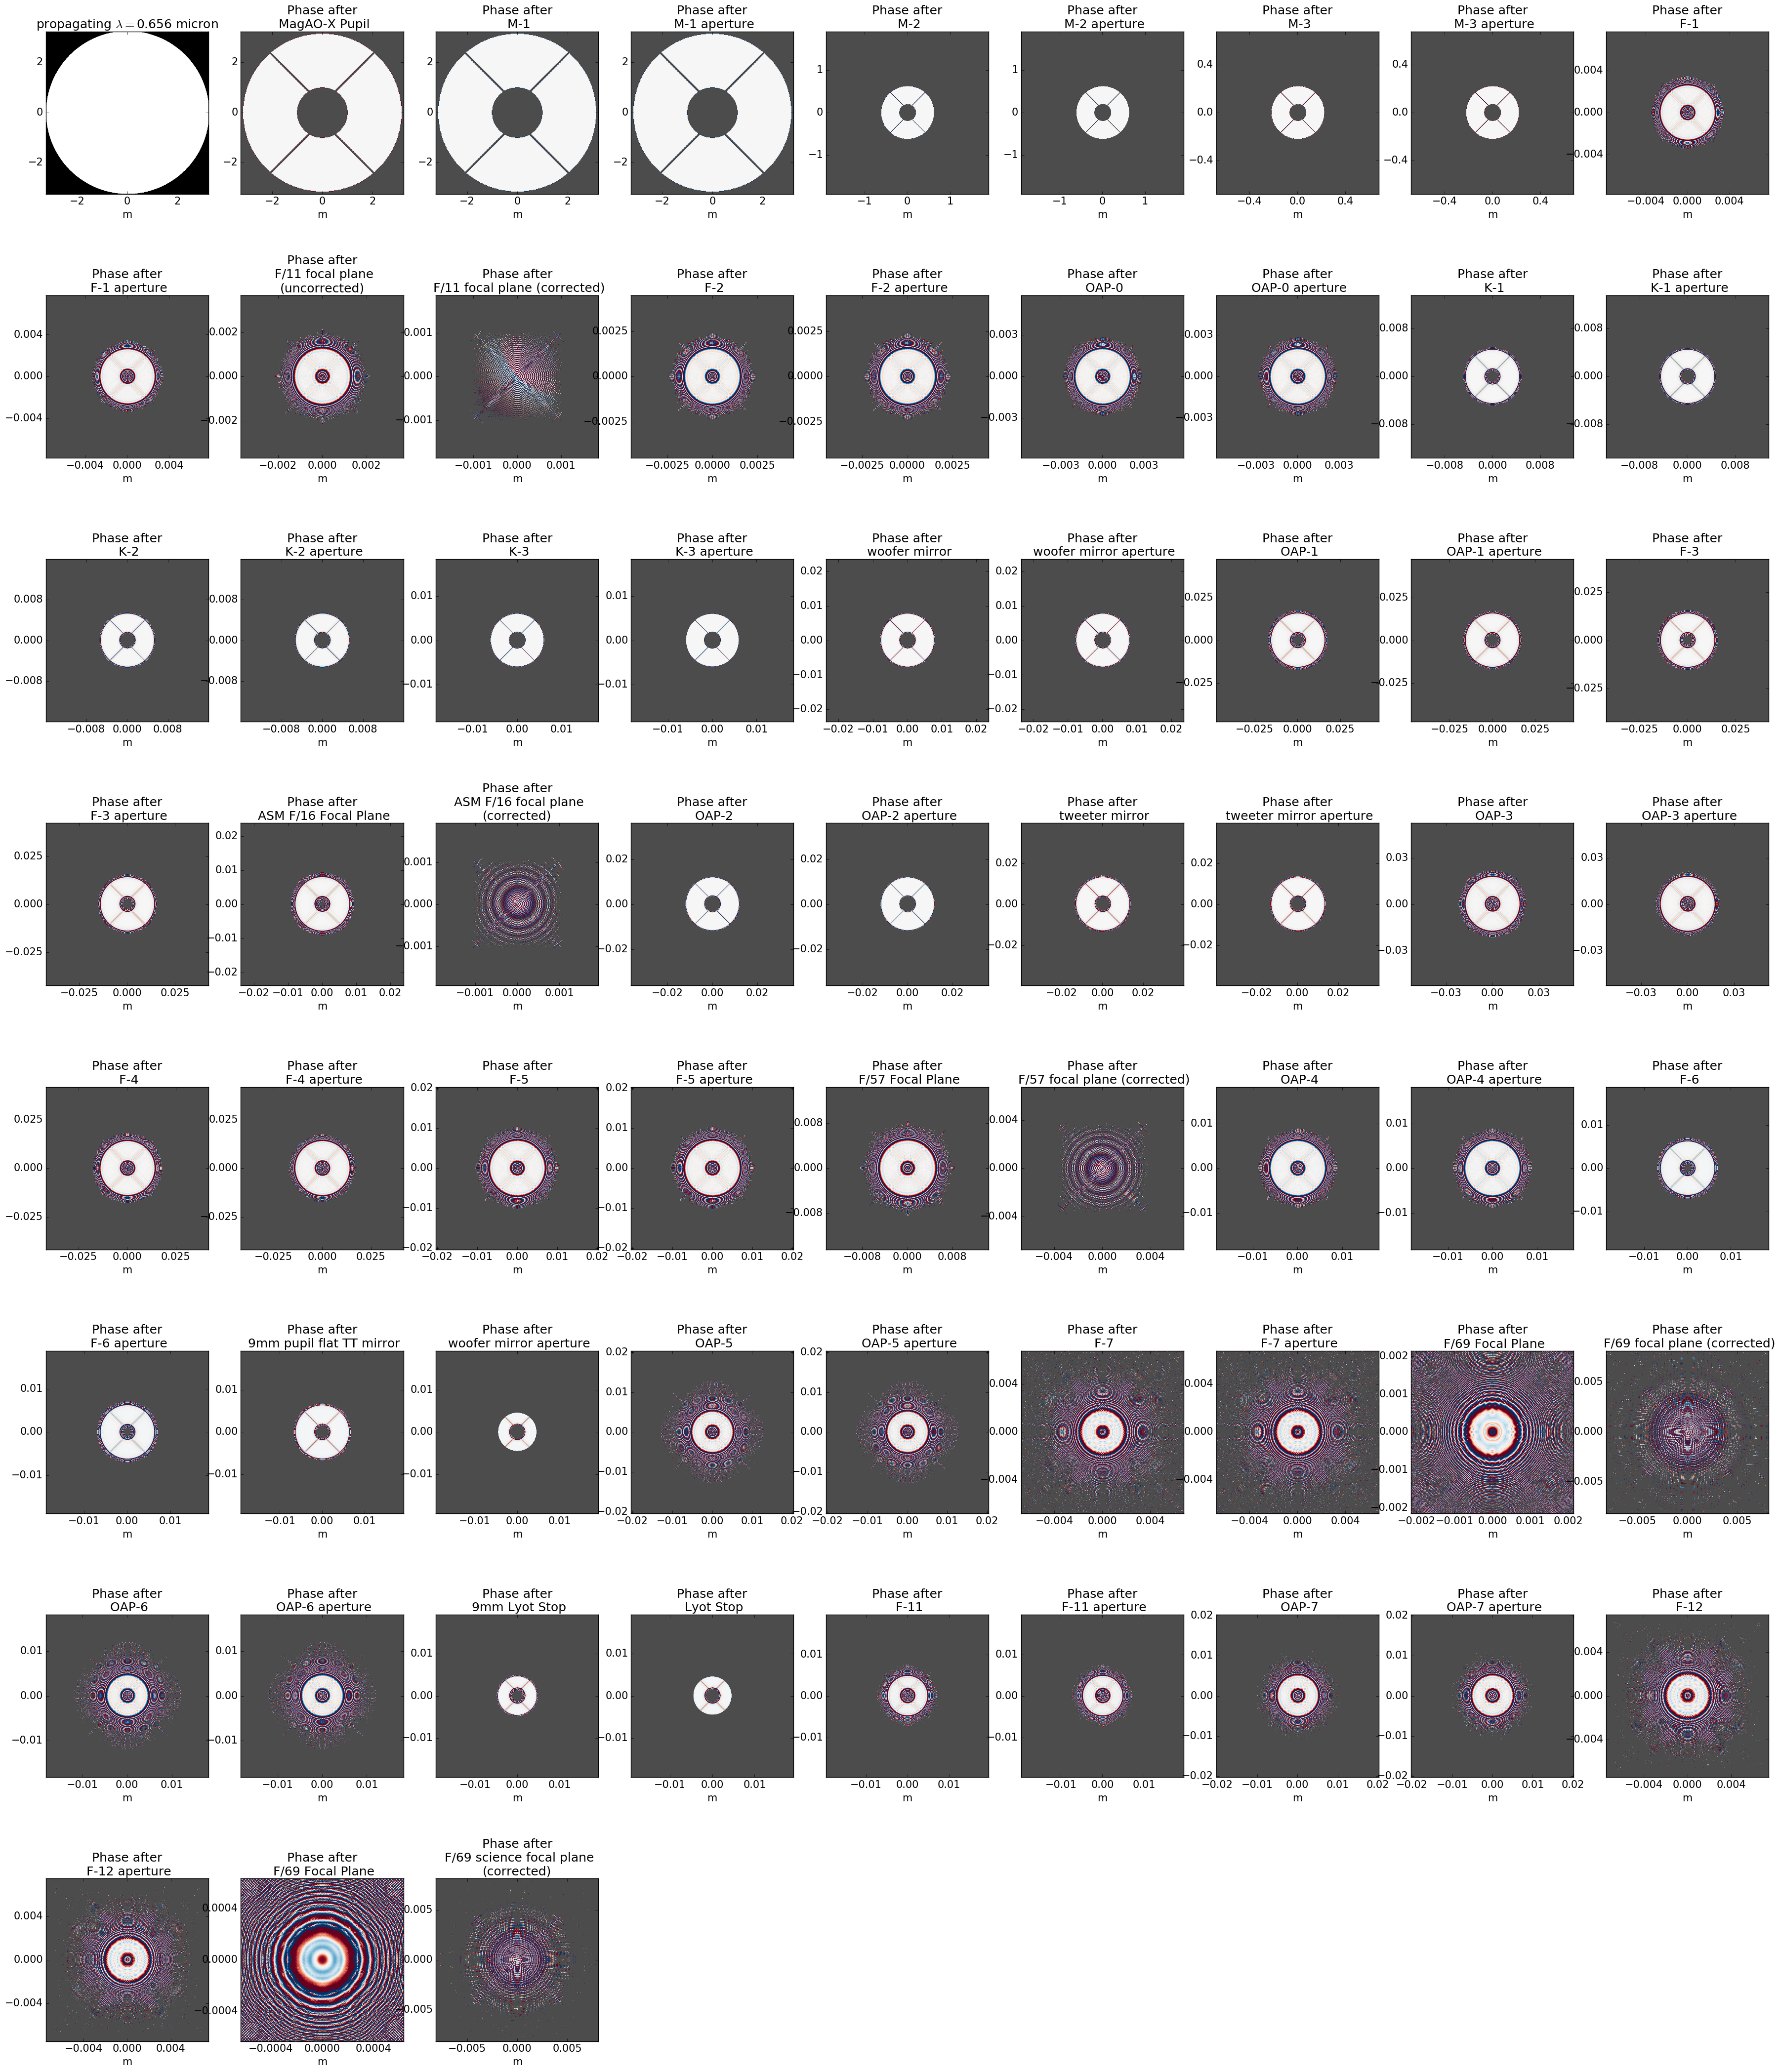

In [26]:
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=[45,54])
f69sci_psf, f69sci_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True, save_intermediates=True)

## F/69 Science PSF

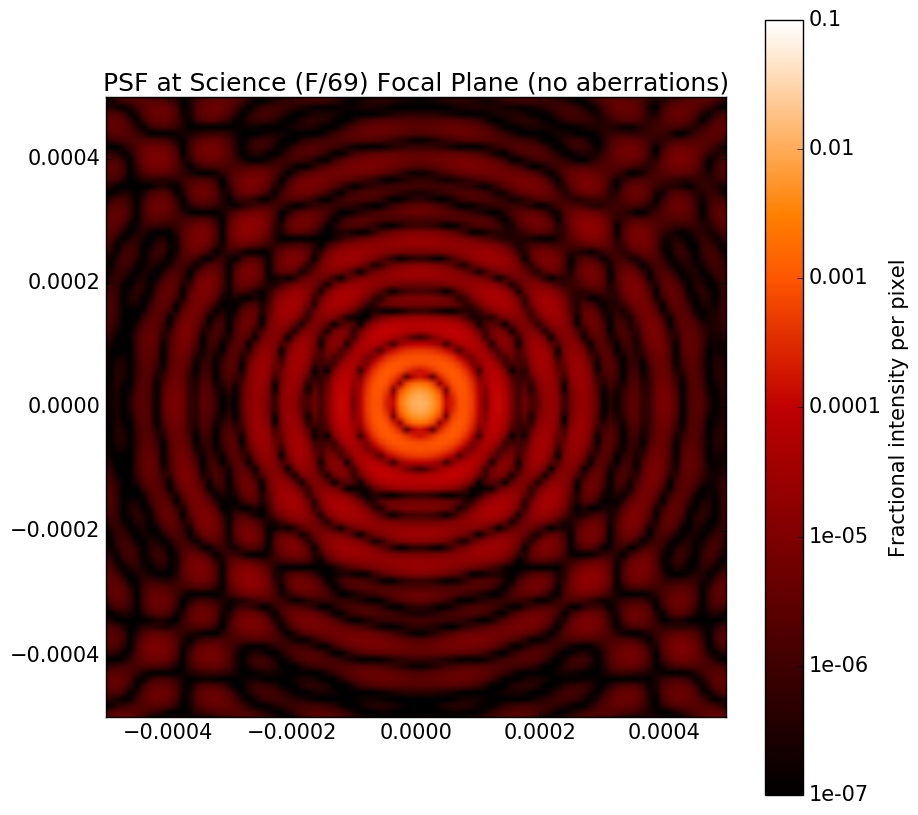

In [27]:
plt.figure(figsize=[10,10])
poppy.display_PSF(f69sci_psf, imagecrop=0.001)
plt.title("PSF at Science (F/69) Focal Plane (no aberrations)")

## Write PSF to FITS file

In [28]:
f69sci_psf[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1536                                                  
NAXIS2  =                 1536                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 6.56000000000000E-07 / Weighted mean wavelength in meters             
DIFFLMT =  0.02088625984934805 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    3 / Oversampling factor for FFTs in computation    
DET_SAMP=                    3 / Oversampling factor for MFT to detector plane  
PIXELSCL= 1.05861583581023E-05 / Pixel scale in meters/pixel                    
DIAM    =             6.4784

In [29]:
f69sci_psf[0].writeto('f69scifp_WithoutAberration_PSF.fits')